## Demo of scalable GPCs with additive noise on a three-class case

In [1]:
import numpy as np
import gpflow
from scipy.cluster.vq import kmeans
from likelihoods_GPCnoise import MultiClass_Unifying, MultiClass_SoftMax_Aug
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

### Generate synthetic three-class data from GP prior

In [2]:
np.random.seed(3)
num_classes = 3
num_data = 400
X = np.random.rand(num_data,2)
dists = np.zeros((num_data,num_data))
for i in range(num_data):
    for j in range(num_data):
        dists[i,j] = np.sum(np.square(X[i,:] - X[j,:]))
K = np.exp(-0.5*dists/0.04) + np.eye(num_data)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(num_data,num_classes))
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

### Train GPCs using step, multinomial probit/logit and softmax likelihoods

In [3]:
# Setup the experiment
a_list = [0., 1., 2.897] # a = 0 -> step likelihood
                                    # a = 1 -> multinomial probit likelihood
                                    # a = 2.897 -> multinomial logit likelihood
M = 32 # inducing size

# Run sparse classification
models = []
for u in range(4):
    kernel = gpflow.kernels.Matern32(input_dim=2, lengthscales=0.5, ARD=True)
    Z = kmeans(X, M)[0]
    feature = gpflow.features.InducingPoints(Z)

    if u <= 2: # GPC-I, GPC-II, GPC-III
        m = gpflow.models.SVGP(X, Y, kern=kernel,
            likelihood=MultiClass_Unifying(3, a=a_list[u]),
            feat=feature, num_latent=3)
        m.likelihood.invlink.epsilon.trainable = True
    else: # GPCsm
        m = gpflow.models.SVGP(X, Y, kern=kernel,
            likelihood=MultiClass_SoftMax_Aug(3),
            feat=feature, num_latent=3)
    
    opt = gpflow.train.AdamOptimizer(0.01)
    opt.minimize(m, maxiter=5000)
    
    models.append(m)

### Make plots

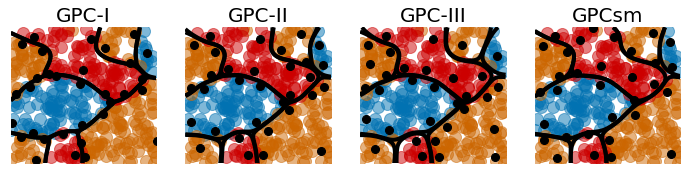

In [5]:
def gridParams():
    mins = [0., 0.] 
    maxs = [1., 1.]
    nGrid = 100
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot

def plot(m, ax, title):
    col1 = '#0172B2'
    col2 = '#CC6600'
    col3 = '#CC0000'
    mins, maxs, xx, yy, Xplot = gridParams()
    p,_ = m.predict_y(Xplot)
    ax.plot(X[:,0][Y[:,0]==0], X[:,1][Y[:,0]==0], 'o', color=col1, ms=12, alpha=0.5)
    ax.plot(X[:,0][Y[:,0]==1], X[:,1][Y[:,0]==1], 'o', color=col2, ms=12, alpha=0.5)
    ax.plot(X[:,0][Y[:,0]==2], X[:,1][Y[:,0]==2], 'o', color=col3, ms=12, alpha=0.5)
    Z = m.feature.Z.read_value()
    ax.plot(Z[:,0], Z[:,1], 'ko', ms=8)
    ax.set_title(title, fontsize=20)
    ax.contour(xx, yy, p[:,0].reshape(*xx.shape), [0.5],
            colors='k', linewidths=4.,zorder=100)
    ax.contour(xx, yy, p[:,1].reshape(*xx.shape), [0.5],
            colors='k', linewidths=4.,zorder=100)
    ax.contour(xx, yy, p[:,2].reshape(*xx.shape), [0.5],
            colors='k', linewidths=4.,zorder=100) 
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

pdf = PdfPages('demo_multiclass.pdf')
    
fig, axes = plt.subplots(1, len(models), figsize=(12, 2.5), sharex=True, sharey=True)
titles = ['GPC-I','GPC-II','GPC-III','GPCsm']
for i, m in enumerate(models):
    plot(m, axes[i], titles[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])
pdf.savefig()
pdf.close()